In [1]:
import numpy as np
import matplotlib.pyplot as plt

def monotone_nearest_path(x, y, allow_equal_y=True, max_dx=None, max_dist=None):
    x = np.asarray(x); y = np.asarray(y)
    idx = np.argsort(x)                 # 先按 x 排序
    xs, ys = x[idx], y[idx]

    path_idx = [0]                      # 从最左点开始
    curr = 0

    while True:
        x0, y0 = xs[curr], ys[curr]

        # 候选：在右侧、且不下降
        j = np.arange(curr+1, len(xs))
        mask = (xs[j] > x0)
        if allow_equal_y:
            mask &= (ys[j] >= y0)
        else:
            mask &= (ys[j] > y0)

        if max_dx is not None:
            mask &= (xs[j] - x0) <= max_dx

        cand = j[mask]
        if cand.size == 0:
            break

        dx = xs[cand] - x0
        dy = ys[cand] - y0
        dist = np.hypot(dx, dy)

        if max_dist is not None:
            ok = dist <= max_dist
            cand, dist = cand[ok], dist[ok]
            if cand.size == 0:
                break

        # 选距离最小的
        next_j = cand[np.argmin(dist)]

        path_idx.append(next_j)
        curr = next_j

    return xs[path_idx], ys[path_idx], idx[path_idx]

In [2]:
import numpy as np
import pwlf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

input_file = "../input_file/PrestaShop.csv" #Input data 

df_composer = pd.read_csv(input_file)
# Prepare the data for pwlf
x = df_composer['accumulative_raw'].values
y = df_composer['complexity_raw'].values

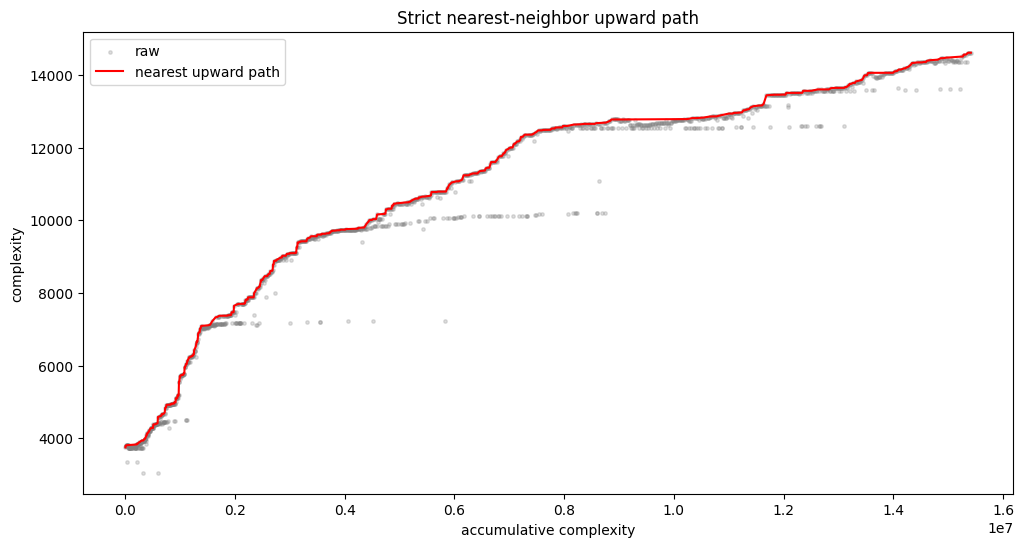

In [3]:
# ===== 使用示例 =====
x_path, y_path, _ = monotone_nearest_path(x, y)

plt.figure(figsize=(12,6))
# 原始灰色散点
idx = np.argsort(x)
plt.scatter(np.array(x)[idx], np.array(y)[idx], s=6, alpha=0.25, color='gray', label='raw')

# 选出的路径画成红线
plt.plot(x_path, y_path, lw=1.5, color='red', label='nearest upward path')

plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.title('Strict nearest-neighbor upward path')
plt.legend()
plt.show()

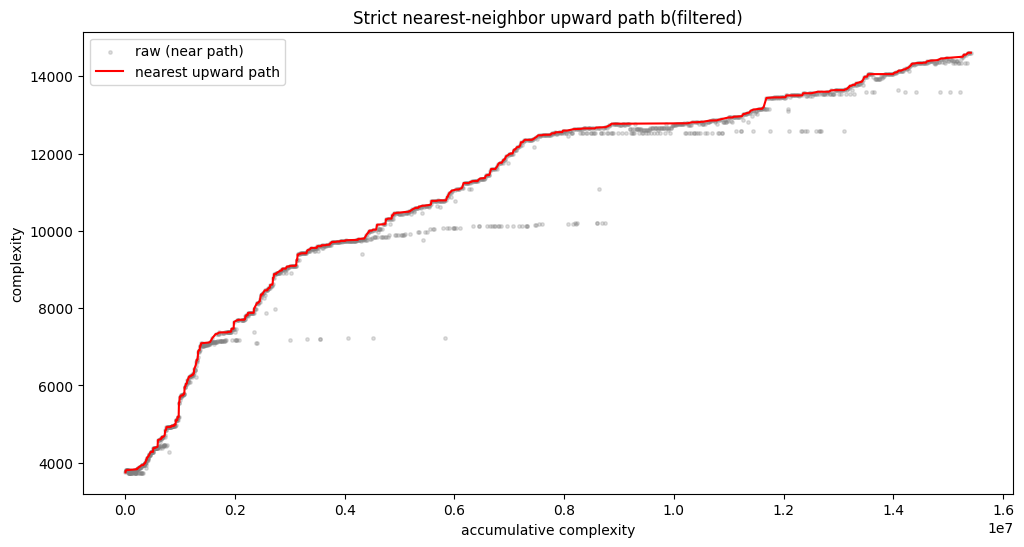

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已有 x, y, x_path, y_path
idx = np.argsort(x)

# 定义容忍度，比如 50（数值可调节，越小越贴近路径）
tolerance = 50  

# 计算每个点到路径的最小距离（在 y 维度上）
# np.abs(y_i - y_path) 得到矩阵，然后取最小值
distances = np.min(np.abs(np.array(y)[:, None] - y_path), axis=1)

# 只保留距离路径小于容忍度的点
mask = distances < tolerance

plt.figure(figsize=(12,6))
plt.scatter(np.array(x)[idx][mask[idx]], np.array(y)[idx][mask[idx]], 
            s=6, alpha=0.25, color='gray', label='raw (near path)')

# 画路径
plt.plot(x_path, y_path, lw=1.5, color='red', label='nearest upward path')

plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.title('Strict nearest-neighbor upward path b(filtered)')
plt.legend()
plt.show()


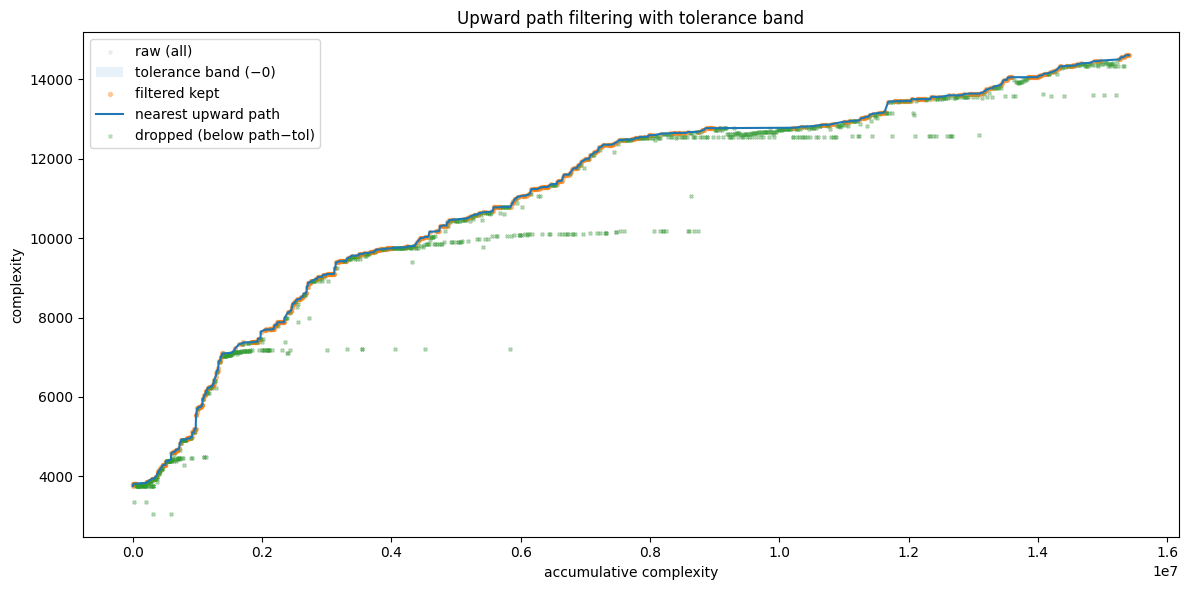

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ---- 安全转换 & 排序（很重要：np.interp 需要单调递增的 x）----
x = np.asarray(x)
y = np.asarray(y)
x_path = np.asarray(x_path)
y_path = np.asarray(y_path)

# 确保路径按 x 递增
order = np.argsort(x_path)
x_path = x_path[order]
y_path = y_path[order]

# ---- 辅助函数：给每个 x 找到路径上的 y（含边界处理）----
def interpolate_path(x_all, x_path, y_path, clip_to_domain=True):
    """
    x_all: 任意顺序
    clip_to_domain=True 时：把超出 [x_path.min, x_path.max] 的 x 截到边界，
    避免 np.interp 用端点常数外推导致奇怪的水平带。
    """
    if clip_to_domain:
        x_min, x_max = x_path[0], x_path[-1]
        x_all_clipped = np.clip(x_all, x_min, x_max)
        return np.interp(x_all_clipped, x_path, y_path)
    else:
        # 默认外推：用端点 y 值
        return np.interp(x_all, x_path, y_path)

# ---- 计算路径上的 y，并按“高于路径-容忍度”筛选 ----
y_on_path = interpolate_path(x, x_path, y_path, clip_to_domain=True)

tolerance = 0   # 👉 可改成 20/30/50 做更宽松的筛选
mask_keep = y >= (y_on_path - tolerance)   # True=保留；False=丢弃

# 也可以一键“删除下面的点”（真正删掉，不画也不参与后续拟合）：
x_kept = x[mask_keep]
y_kept = y[mask_keep]

# 为了可读性，按 x 升序画图
idx_all  = np.argsort(x)
idx_keep = np.argsort(x_kept)

plt.figure(figsize=(12,6))

# 灰色淡淡地画全部原始点（可选）
plt.scatter(x[idx_all], y[idx_all], s=6, alpha=0.10, color='gray', label='raw (all)')

# 画“容忍带”（路径下方 tolerance 的阴影，可视化你在“踢掉”的区域；tolerance=0 时基本贴线）
# 为避免 fill_between 抖动，我们在路径节点上画带并连接
plt.fill_between(
    x_path, y_path - tolerance, y_path,
    alpha=0.10, step=None, label=f'tolerance band (−{tolerance})'
)

# 只画保留下来的点（更清晰）
plt.scatter(x_kept[idx_keep], y_kept[idx_keep], s=8, alpha=0.35, label='filtered kept')

# 画红色路径
plt.plot(x_path, y_path, lw=1.5, label='nearest upward path')

# 额外：把“被踢掉”的点也标出来（可选，便于检查阈值）
dropped = ~mask_keep
if dropped.any():
    plt.scatter(x[dropped], y[dropped], s=6, alpha=0.35, marker='x', label='dropped (below path−tol)')

plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.title('Upward path filtering with tolerance band')
plt.legend()
plt.tight_layout()
plt.show()

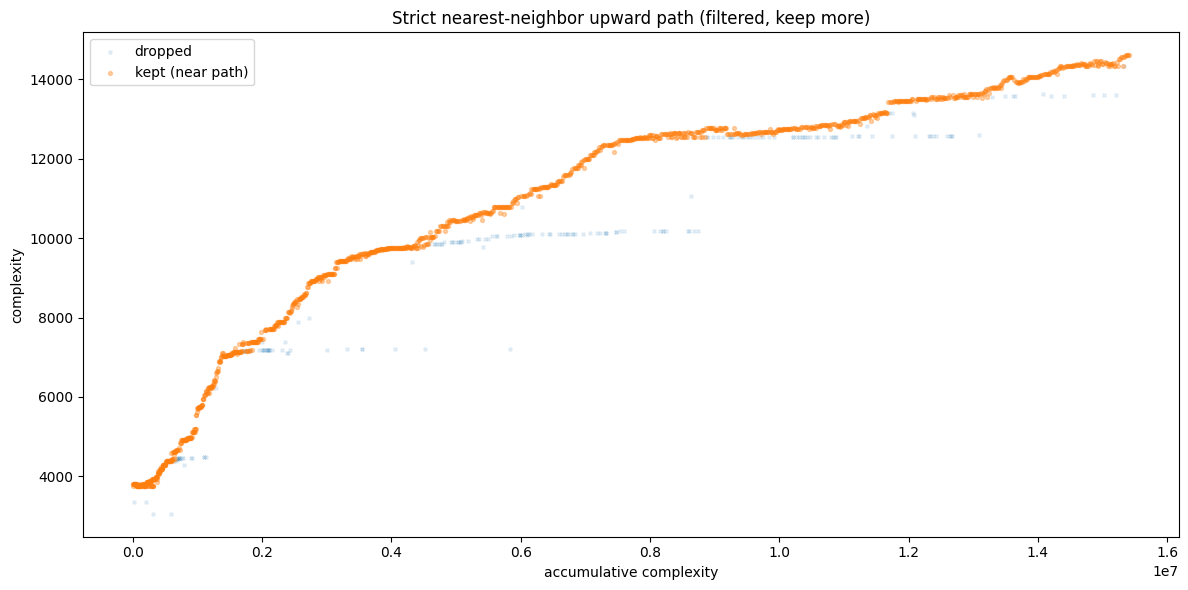

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def keep_more_points(x, y, x_path, y_path,
                     abs_tol=100.0,      # 绝对容忍（↑更宽）
                     rel_tol=0.012,      # 相对容忍（按路径高度比例；↑更宽）
                     k_mad=2.0,          # 局部稳健波动权重（↑更宽）
                     q_low=15,           # 分箱低分位兜底（↓更宽；如 10）
                     jump_min=60.0,      # 识别“台阶跳升”的阈值
                     jump_bonus=80.0,    # 台阶附近额外放宽（↑更宽）
                     x_radius_frac=0.03, # 台阶影响半径（占 x 范围比例；↑更宽）
                     max_drop_cap=220.0  # 允许向下最大下探（↑更宽）
                    ):
    x = np.asarray(x); y = np.asarray(y)
    x_path = np.asarray(x_path); y_path = np.asarray(y_path)

    # 路径按 x 递增
    order = np.argsort(x_path)
    x_path = x_path[order]; y_path = y_path[order]

    # 路径插值（裁剪到路径范围，避免端点水平外推）
    x_min, x_max = x_path[0], x_path[-1]
    x_clip = np.clip(x, x_min, x_max)
    y_on_path = np.interp(x_clip, x_path, y_path)

    # 残差：点相对路径的高度（负=在路径下方）
    r = y - y_on_path

    # 分箱做局部统计
    N = len(x)
    n_bins = max(20, min(120, N // 150))
    edges = np.linspace(x.min(), x.max(), n_bins + 1)
    bin_id = np.digitize(x, edges) - 1
    bin_id = np.clip(bin_id, 0, n_bins - 1)

    # 基础阈值（负数，越负越宽）
    thr = -(abs_tol + rel_tol * y_on_path) * np.ones_like(y, float)

    # 叠加 MAD 稳健尺度
    for b in range(n_bins):
        idx = (bin_id == b)
        if idx.sum() < 15: 
            continue
        r_b = r[idx]
        med = np.median(r_b)
        mad = np.median(np.abs(r_b - med))
        sigma = 1.4826 * mad
        thr[idx] -= k_mad * sigma

    # 分箱低分位兜底（确保每箱都留一批“靠近平台”的点）
    for b in range(n_bins):
        idx = (bin_id == b)
        if idx.sum() < 15:
            continue
        r_b = r[idx]
        thr_q = np.percentile(r_b, q_low)
        thr[idx] = np.minimum(thr[idx], thr_q)

    # 台阶跳升附近额外放宽（照顾新平台略低于红线的簇）
    dy = np.diff(y_path)
    jump_idx = np.where(dy >= jump_min)[0] + 1
    jump_x = x_path[jump_idx]
    x_radius = x_radius_frac * (x.max() - x.min())

    bonus = np.zeros_like(y, float)
    for jx in jump_x:
        near = np.abs(x - jx) <= x_radius
        bonus[near] += jump_bonus
    thr -= bonus

    # 最大下探保护
    thr = np.maximum(thr, -max_drop_cap)

    mask_keep = r >= thr
    return mask_keep, y_on_path

# ===== 直接使用（推荐 Balanced 档）=====
# 三个预设：
presets = {
    "Conservative": dict(abs_tol=60,  rel_tol=0.008, k_mad=1.5, q_low=20, jump_min=60, jump_bonus=40, x_radius_frac=0.025, max_drop_cap=160),
    "Balanced":     dict(abs_tol=100, rel_tol=0.012, k_mad=2.0, q_low=15, jump_min=60, jump_bonus=80, x_radius_frac=0.03,  max_drop_cap=220),
    "Generous":     dict(abs_tol=140, rel_tol=0.016, k_mad=2.5, q_low=10, jump_min=50, jump_bonus=100,x_radius_frac=0.035, max_drop_cap=280),
}

mask_keep, y_on_path = keep_more_points(x, y, x_path, y_path, **presets["Balanced"])

# 可视化（区分 kept / dropped）
idx = np.argsort(x)
plt.figure(figsize=(12,6))
plt.scatter(np.array(x)[~mask_keep], np.array(y)[~mask_keep], s=6, alpha=0.15, marker='x', label='dropped')
plt.scatter(np.array(x)[mask_keep],  np.array(y)[mask_keep],  s=8, alpha=0.35,              label='kept (near path)')
# plt.plot(np.array(x_path)[np.argsort(x_path)], np.array(y_path)[np.argsort(y_path)], lw=1.5, label='nearest upward path')
plt.xlabel('accumulative complexity'); plt.ylabel('complexity')
plt.title('Strict nearest-neighbor upward path (filtered, keep more)')
plt.legend(); plt.tight_layout(); plt.show()


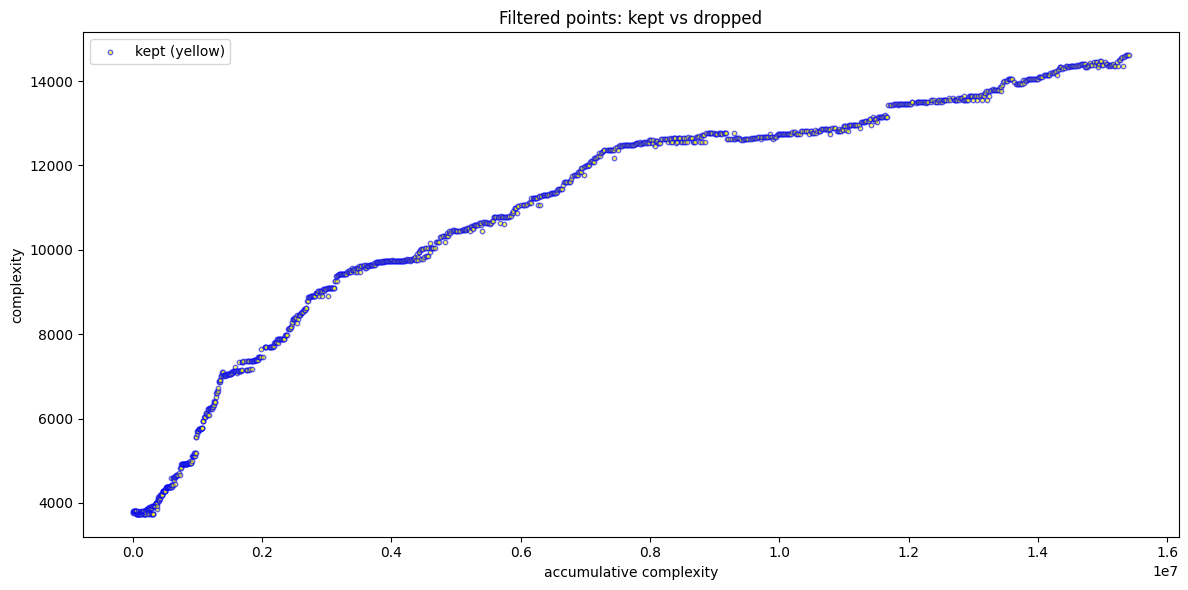

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 黄色点
x_keep = np.array(x)[mask_keep]
y_keep = np.array(y)[mask_keep]

# 被丢弃的点
x_drop = np.array(x)[~mask_keep]
y_drop = np.array(y)[~mask_keep]

plt.figure(figsize=(12,6))


# 画保留点（黄色）
plt.scatter(x_keep, y_keep, s=10, alpha=0.6, color='yellow', edgecolors='blue', label='kept (yellow)')

plt.xlabel("accumulative complexity")
plt.ylabel("complexity")
plt.title("Filtered points: kept vs dropped")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
def fit_model(X, Y, m, cv_splits=5, random_state=42, is_fast=False):
    """拟合 m 段并计算各类指标"""
    mdl = pwlf.PiecewiseLinFit(X, Y)
    if is_fast == False:
        breaks = mdl.fit(m) 
    else: 
        breaks = mdl.fastfit(m) 
    y_hat = mdl.predict(X)

    n   = len(Y)
    rss = float(np.sum((Y - y_hat)**2))
    mse = rss / n 
    mae = float(mean_absolute_error(Y, y_hat)) #Mean Absolut Error 
    tss = float(np.sum((Y - np.mean(Y))**2)) #Total Sum of Squares, TSS
    r2  = 1 - rss / tss if tss > 0 else np.nan

    # 参数个数惩罚：常用近似 k = 2*m（斜率/截距 + 断点自由度）
    k   = 2 * m
    aic = n * np.log(mse) + 2 * k #在保证模型拟合数据的同时，尽量避免模型过于复杂（overfitting）。
    bic = n * np.log(mse) + k * np.log(n) #在拟合效果和模型复杂度之间做权衡，但 比 AIC 惩罚更严格。
    r2_adj = 1 - ((rss/(n - k)) / (tss/(n - 1))) if (n - k) > 0 and (tss > 0) else np.nan

#     # 交叉验证 MSE
#     kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
#     cv_mses = []
#     for tr, te in kf.split(X):
#         Xtr, Ytr = X[tr], Y[tr]
#         Xte, Yte = X[te], Y[te]
#         mdl_cv = pwlf.PiecewiseLinFit(Xtr, Ytr)
#         mdl_cv.fit(m)
#         Ypred = mdl_cv.predict(Xte)
#         cv_mses.append(mean_squared_error(Yte, Ypred))
#     cv_mse = float(np.mean(cv_mses))

    return {
        "m": m,
        "breaks": breaks,
        "train_MSE": mse,
        "train_MAE": mae,
        
        "R2": r2,
        "R2_adj": r2_adj,
        "AIC": aic,
        "BIC": bic,
#         "CV_MSE": cv_mse,
    }

In [12]:
def evaluate_all_segments(X, Y, min_m=2, max_m=40, criterion="BIC",
                          cv_splits=5, random_state=42, early_stop=True, is_fast=False):
    """
    遍历分段数，返回每个 m 的指标，并根据 criterion 选最佳。
    criterion ∈ {"BIC","AIC","CV_MSE","R2_adj","MSE"}
      - MSE 越小越好（MSE 指训练集 MSE，对应键为 'train_MSE'）
      - R2_adj 越大越好
    """
    X = np.asarray(X).reshape(-1)
    Y = np.asarray(Y).reshape(-1)
    n = len(Y)

    # 基本可行性限制：至少保证每段有≥2个点（保守些）
    max_feasible = max(min(max_m, n // 2), min_m)
    ms = list(range(min_m, max_feasible + 1))

    crit = criterion.upper()
    # 将 "MSE" 统一映射到结果 dict 中的键名
    metric_key = {"MSE": "train_MSE"}.get(crit, crit)

    results = []
    for m in ms:
        t0 = time.perf_counter()
        try:
            res = fit_model(X, Y, m, cv_splits=cv_splits, random_state=random_state, is_fast=is_fast)
            t1 = time.perf_counter()
            res["time_s"] = t1 - t0
            results.append(res)
            
        except Exception as e:
            t1 = time.perf_counter()
            # 若某些 m 因数据分布问题无法拟合，记录错误并继续
            results.append({"m": m, "error": str(e), "time_s": float(t1 - t0)})

        # 提前停止邏輯 （基於所選 criterion）
        if early_stop and len(results) >= 3:
            last_three = [r for r in results[-3:] if "error" not in r and metric_key in r]
            if len(last_three) == 3:
                v0, v1, v2 = [r[metric_key] for r in last_three]
                if crit in ("MSE"):
                    # 越小越好：若連續三次指標遞增，說明開始惡化，停止
                    if (v2 > v1) and (v1 > v0):
                        break
                elif crit == "R2_ADJ":
                    # 越大越好：若连续三次指标递减，停止
                    if (v2 < v1) and (v1 < v0):
                        break

    # 选最优
    valid = [r for r in results if "error" not in r]
    if not valid:
        raise RuntimeError("没有成功的拟合结果，请检查数据或放宽可行范围。")

    if crit in ("MSE"):
        # 越小越好；NaN/缺失时丢到 +∞
        def safe_val(r):
            v = r.get(metric_key, np.inf)
            return v if (v is not None and not np.isnan(v)) else np.inf
        best = min(valid, key=safe_val)

    # 打印摘要
    print("=== Summary ===")
    for r in valid:
        print(f"m={r['m']:>2} | "
              f"MSE={r['train_MSE']:.3f} | "
              f"time={r['time_s']:.2f} s | "
              f"breaks={np.round(r['breaks'],3)}"
             
             )
        print("--------------------------")
    shown_key = metric_key 
    print(f"\n✅ Best by {criterion}: Segments(m)={best['m']}, MSE={best[shown_key]:.3f}, time:{best['time_s']:.2f}, breaks={np.round(best['breaks'], 6)}")
    return {"all": results, "best": best}

In [15]:
min_s = 5
max_s = 10
results = evaluate_all_segments(x_keep, y_keep, min_m=min_s, max_m=max_s, criterion="MSE",is_fast=False)

=== Summary ===
m= 5 | MSE=23502.152 | time=1.27 s | breaks=[3.74934000e+03 1.51592848e+06 2.94396199e+06 8.04557217e+06
 1.04377552e+07 1.54123556e+07]
--------------------------
m= 6 | MSE=13557.285 | time=4.09 s | breaks=[3.74934000e+03 8.28680402e+05 1.32357786e+06 3.01926579e+06
 8.04851618e+06 1.04599509e+07 1.54123556e+07]
--------------------------
m= 7 | MSE=9338.075 | time=6.46 s | breaks=[3.74934000e+03 8.32839243e+05 1.32363377e+06 3.20738558e+06
 5.98287449e+06 7.56185605e+06 1.05204546e+07 1.54123556e+07]
--------------------------
m= 8 | MSE=7754.516 | time=44.73 s | breaks=[3.74934000e+03 8.41892964e+05 1.37465160e+06 2.15927811e+06
 2.91249158e+06 6.10769188e+06 7.54973920e+06 1.05352213e+07
 1.54123556e+07]
--------------------------
m= 9 | MSE=6523.548 | time=193.12 s | breaks=[3.74934000e+03 2.76727742e+05 9.03909656e+05 1.38584486e+06
 2.03116547e+06 2.95992701e+06 6.32040143e+06 7.48004640e+06
 1.06149922e+07 1.54123556e+07]
--------------------------
m=10 | MSE=5

In [16]:
# Extract the "best" result (with chosen m)
best_result = results['best']

# Get the breakpoints array
breakpoints = best_result['breaks']

# print("Breakpoints as array:", breakpoints)
print("Breakpoints as Python list:", breakpoints.tolist())

Breakpoints as Python list: [3749.34, 272235.6894377316, 900280.1226278399, 1385368.440748475, 1948286.2711373565, 3205187.8527984084, 4264067.883433883, 6505355.117900733, 7489677.642229545, 10525789.374097552, 15412355.620000016]


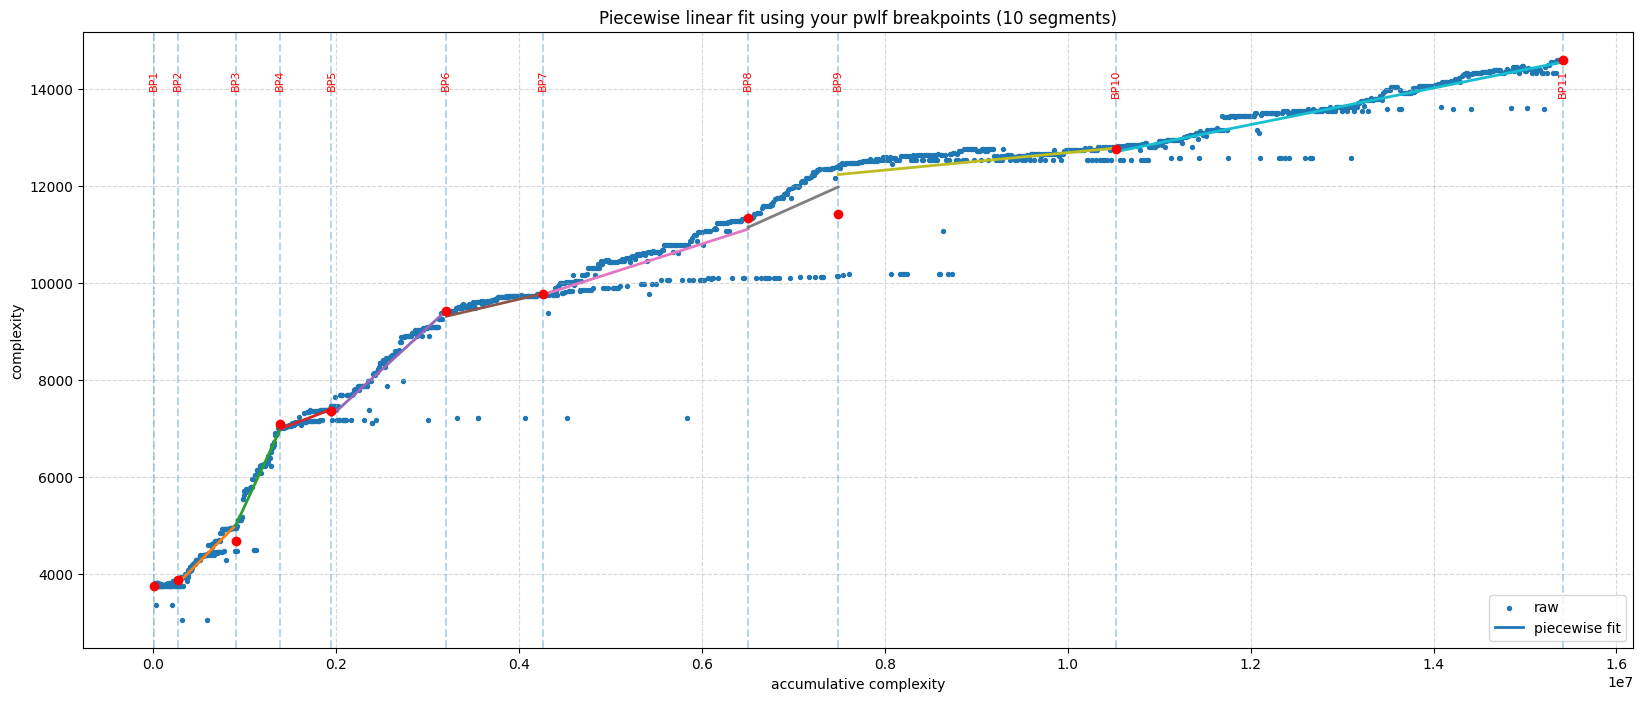

In [17]:
plt.figure(figsize=(20, 8))
plt.scatter(x, y, s=8, label='raw')

requested_segments = len(breakpoints) - 1

for i in range(len(breakpoints) - 1):
    x0, x1 = breakpoints[i], breakpoints[i+1]
    mask = (x >= x0) & ((x < x1) if i < len(breakpoints)-2 else (x <= x1))
    Xi, Yi = x[mask], y[mask]

    if Xi.size >= 2:
        X1 = np.vstack([np.ones_like(Xi), Xi]).T
        beta, *_ = np.linalg.lstsq(X1, Yi, rcond=None)
        a, b = beta
        xs = np.linspace(x0, x1, 200)
        ys = a + b*xs
    elif Xi.size == 1:
        xs = np.linspace(x0, x1, 200)
        ys = np.full_like(xs, Yi.item())
    else:
        xs = np.linspace(x0, x1, 200)
        ys = np.full_like(xs, y.mean())
    
    plt.plot(xs, ys, linewidth=2, label='piecewise fit' if i==0 else None)

# --- draw vertical lines and annotate breakpoints ---
for j, bp in enumerate(breakpoints):
    plt.axvline(bp, linestyle='--', alpha=0.3)
    # mark point on axis
    plt.scatter(bp, np.interp(bp, x, y), color='red', zorder=5)
    # label
    plt.text(bp, plt.ylim()[1]*0.95, f'BP{j+1}', rotation=90,
             va='top', ha='center', fontsize=8, color='red')

plt.title(f'Piecewise linear fit using your pwlf breakpoints ({requested_segments} segments)')
plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()